# Assignment 2

## Roll numbers:


- Sarthak Mishra: 2023701027 
- Samaksh Ujjawal: 2024702013
- Rohit Pawar: 2024701025
- Soham Patil: 2024701005


### Instructions
 * Fill in the roll-number in the cell above.
 * Code must be submitted in Python in jupyter notebooks. We highly recommend using anaconda/miniconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 *  Most of the questions require you to **code your own functions** unless there is a need to call in the abilities of the mentioned libraries, such as Visualisation from Open3D. Make sure your code is modular since you will be reusing them for future assignments. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 *  All the representations are expected to be in a right-hand coordinate system.
<!--  * Answer to the descriptive questions should be answered in your own words. Copy-paste answers will lead to penalty. -->
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit the notebooks in the repo and any other results files under the result folder in the GitHub Classroom repo. 
 * This is a group assignment. Discussions are encouraged but any sharing of code among different teams will be penalized. 

## SECTION 1: ICP with SVD

### 1.1 Perform Procrustes alignmenton two point clouds with (given) known correspondences. (5 Points)

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2).

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

<b>Use root mean squared error (RSME) as the alignment error metric.</b>

Make sure your code is modular as we will use this function in the next sub-part.

We will again use our own getTransform function to generate the 4x4 Transformation matrix to transform the pointcloud to P2, so make sure your code works for any general Transformation matrix

In [9]:
## Random Transform Implementation
import numpy as np
import math

def alpha_rot(alpha):
    return np.array([
        [   1.0,    0.0,                0.0             ],
        [   0.0,    math.cos(alpha),   -math.sin(alpha) ],
        [   0.0,    math.sin(alpha),    math.cos(alpha) ]
        ],dtype=np.float32)

def beta_rot(beta):
    return np.array([
        [   math.cos(beta),     0.0,    math.sin(beta)  ],
        [   0.0,                1.0,    0.0             ],
        [  -math.sin(beta),     0.0,    math.cos(beta)  ]
        ],dtype=np.float32)

def gamma_rot(gamma):
    return np.array([
        [   math.cos(gamma),   -math.sin(gamma),    0.0 ],
        [   math.sin(gamma),    math.cos(gamma),    0.0 ],
        [   0.0,                0.0,                1.0 ]
        ],dtype=np.float32)
        
def euler2rm(alpha, beta, gamma):
    return np.matmul(alpha_rot(alpha),np.matmul(beta_rot(beta),gamma_rot(gamma)))

def getTransform():
    R = euler2rm(np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi))
    T = np.array([
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)]
    ])
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T.flatten()
    
    return transformation_matrix

In [10]:
## 1.1 Solution
import open3d as o3d

def invert_transform(matrix):
    rotation_matrix = matrix[:3, :3]
    translation_vector = matrix[:3, 3]

    inv_rotation_matrix = np.transpose(rotation_matrix)
    inv_translation_vector = -np.matmul(inv_rotation_matrix, translation_vector)

    inv_matrix = np.eye(4)
    inv_matrix[:3, :3] = inv_rotation_matrix
    inv_matrix[:3, 3] = inv_translation_vector
    
    return inv_matrix

def transform_point_cloud(point_cloud, transformation_matrix, downsample=1.0):
    if downsample < 1.0:
        indices = np.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]

    rotated_points = np.dot(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]

    return transformed_points

def icp_with_svd(pcl0, pcl1, transform):
    pcl1_transformed = transform_point_cloud(pcl1, transform)
    centroid_pcl0 = np.mean(pcl0, axis=0)
    centroid_pcl1 = np.mean(pcl1_transformed, axis=0)
    centered_pcl0 = pcl0 - centroid_pcl0
    centered_pcl1 = pcl1_transformed - centroid_pcl1
    H = centered_pcl0.T @ centered_pcl1
    U, D, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        R[:, 2] *= -1
    t = centroid_pcl0 - R @ centroid_pcl1
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    
    return T

def rsme(pcl0,pcl1,transform):
    return np.linalg.norm(pcl0 - transform_point_cloud(pcl1, transform)) / np.sqrt(pcl0.shape[0])

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)

transform0 = getTransform()
transform1 = getTransform()

downsample = 1

pcl0 = transform_point_cloud(pcl_array, transform0, downsample)
pcl1 = transform_point_cloud(pcl_array + np.random.normal(0.0, 1, pcl_array.shape), transform1, downsample)

pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()

opti_transform = np.eye(4)

svd_transform = icp_with_svd(pcl0, pcl1, opti_transform)
opti_transform = svd_transform @ opti_transform
pcl1_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(pcl1, opti_transform))
frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(np.array(frame0.vertices), opti_transform))
vis.update_geometry(pcl1_geom)
vis.update_geometry(frame1)
vis.poll_events()
vis.update_renderer()
error = rsme(pcl0,pcl1,opti_transform)

if error < 2e-0:
    pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
    pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
    vis.update_geometry(pcl0_geom)
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    print(f"Converged in 1 iteration(obviously) with {error} error.")
    print("Expected transformation matrix:")
    print(np.array_str(transform0 @ invert_transform(transform1), precision=4, suppress_small=True))
    print("Final transformation matrix:")
    print(np.array_str(opti_transform, precision=4, suppress_small=True))
else:
    print("Failed to converge")
vis.run()
vis.destroy_window()


Converged in 1 iteration(obviously) with 1.7330390474705737 error.
Expected transformation matrix:
[[  -0.2114   -0.7461    0.6314  754.3228]
 [  -0.7862    0.5136    0.3436 -265.4177]
 [  -0.5807   -0.4238   -0.6951 -289.1341]
 [   0.        0.        0.        1.    ]]
Final transformation matrix:
[[  -0.2114   -0.7461    0.6314  754.3221]
 [  -0.7862    0.5136    0.3436 -265.393 ]
 [  -0.5807   -0.4238   -0.6951 -289.1278]
 [   0.        0.        0.        1.    ]]


<table>
    <tr>
        <td><h3>Task 1.1 Before</h3><img src="./1.1 before.png" width="700"/></td>
        <td><h3>Task 1.1 After</h3><img src="./1.1 after.png" width="700"/></td>
    </tr>
</table>

### 1.2 Implement ICP algorithm with unknown correspondences. (5 Points)

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration. 

Refer to Shubodh's notes to compute correspondences: https://saishubodh.notion.site/Mobile-Robotics-Navigating-from-Theory-to-Application-0b65a9c20edd4081978f4ffad917febb?p=a25686ce1a11409d838d47bcac43ab4b&pm=s#bb9aaf2e316b4db3b399df1742f0444c


251.84686421078635
Converged in 2 iterations with 1.7297870092166687 error.
Expected transformation matrix:
[[ -0.8859   0.4554   0.0885 311.4497]
 [ -0.4436  -0.8873   0.1262 699.9225]
 [  0.136    0.0725   0.9881  28.6155]
 [  0.       0.       0.       1.    ]]
Final transformation matrix:
[[ -0.8859   0.4554   0.0884 311.42  ]
 [ -0.4436  -0.8873   0.1262 699.9423]
 [  0.1359   0.0726   0.9881  28.6203]
 [  0.       0.       0.       1.    ]]


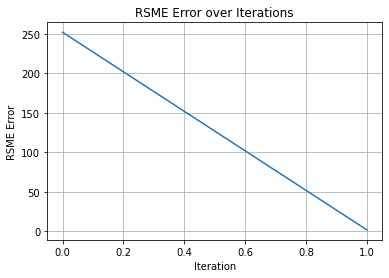

In [15]:
## 1.2 Solution

import matplotlib.pyplot as plt

def compute_correspondences(pcl0, pcl1, transform):
    transformed_pcl1 = transform_point_cloud(pcl1, transform)
    ci = []
    for i in range(pcl0.shape[1]):
        closest_idx = np.argmin(np.linalg.norm(transformed_pcl1 - pcl0[:, i].reshape(pcl0.shape[0], 1), axis=0))
        ci.append(closest_idx)
        transformed_pcl1[:, closest_idx] = np.inf
    ci = np.array(ci)
    matched_pcl1 = pcl1[:, ci]
    return matched_pcl1

errors = []

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)

transform0 = getTransform()
transform1 = getTransform()

downsample = 1

pcl0 = transform_point_cloud(pcl_array, transform0, downsample)
pcl1 = transform_point_cloud(pcl_array + np.random.normal(0.0, 1, pcl_array.shape), transform1, downsample)

pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()
opti_transform = np.eye(4)
for i in range(50):
    matched_pcl1 = compute_correspondences(pcl0, pcl1, opti_transform)
    svd_transform = icp_with_svd(pcl0, matched_pcl1, opti_transform)
    opti_transform = svd_transform @ opti_transform
    pcl1_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(pcl1, opti_transform))
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(np.array(frame0.vertices), opti_transform))
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = rsme(pcl0,pcl1,opti_transform)
    errors.append(error)
    if error < 2e-0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        vis.update_geometry(frame1)
        vis.poll_events()
        vis.update_renderer()
        print(f"Converged in {i+1} iterations with {error} error.")
        print("Expected transformation matrix:")
        print(np.array_str(transform0 @ invert_transform(transform1), precision=4, suppress_small=True))
        print("Final transformation matrix:")
        print(np.array_str(opti_transform, precision=4, suppress_small=True))
        break
    print(error)

if error > 2e-0:
    print("Failed to converge")
vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

<table>
    <tr>
        <td><h3>Task 1.2 Before</h3><img src="./1.2 before.png" width="700"/></td>
        <td><h3>Task 1.2 After</h3><img src="./1.2 after.png" width="700"/></td>
    </tr>
</table>

## SECTION 2: ICP with Lie Groups

### 2.1 Predict the Transformation matrix between 2 point clouds with known correspondences (15 Points)
Perform the same task as 1.1 using Lie Group Optimization from scratch to predict the transformation between the 2 point clouds.

Refer: https://saishubodh.notion.site/Mobile-Robotics-Navigating-from-Theory-to-Application-0b65a9c20edd4081978f4ffad917febb?p=ee55fe5689794693910ab7861bef067b&pm=s#7b82d84766a84b63b91d859579e4886b


366.3088217065293
236.22815573364224
106.29354914836959
35.674288995525394
17.462476736835605
1.7268486152382876
Converged in 5 iterations with 1.7268486152382876 error.
Expected transformation matrix:
[[ -0.9877  -0.1468  -0.0533 617.6886]
 [  0.0582  -0.0295  -0.9979 294.8902]
 [  0.1449  -0.9887   0.0377   2.5124]
 [  0.       0.       0.       1.    ]]
Final transformation matrix:
[[ -0.9877  -0.1468  -0.0534 617.7117]
 [  0.0583  -0.0296  -0.9979 294.8182]
 [  0.1449  -0.9887   0.0378   2.4492]
 [  0.       0.       0.       1.    ]]


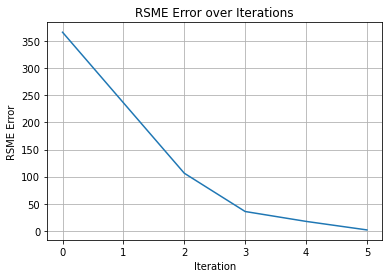

In [16]:
## 2.1 Solution
def skew(vector):
    x, y, z = vector.ravel()
    
    return np.array([
        [ 0, -z,  y],
        [ z,  0, -x],
        [-y,  x,  0]
    ])

def icp_with_lie(pcl0, pcl1, guess_transform):
    pcl1_transformed = transform_point_cloud(pcl1, guess_transform)
    
    residuals = (pcl1_transformed - pcl0).reshape(-1,1)

    jacobian = np.zeros((pcl1.shape[0] * 3, 6))

    for j in range(pcl1_transformed.shape[0]):
        jacobian[3 * j: 3 * j + 3, 0:3] = np.eye(3)
        jacobian[3 * j: 3 * j + 3, 3:6] = -skew(pcl1_transformed[j])

    delta_x = -(np.linalg.pinv(jacobian.T @ jacobian) @ jacobian.T @ residuals)
    return delta_x

def se3_exp(xi):
    w = xi[3:]
    v = xi[:3]
    theta = np.linalg.norm(w)
    if theta < 1e-6:
        R = np.eye(3)
        J = np.eye(3)
    else:
        axis = w / theta
        skew_axis = skew(axis)
        R = np.eye(3) + np.sin(theta) * skew_axis + (1 - np.cos(theta)) * (skew_axis @ skew_axis)
        J = np.eye(3) + ((1 - np.cos(theta)) / (theta**2)) * (skew_axis @ skew_axis) + \
            (theta - np.sin(theta)) / (theta**3) * (skew_axis @ skew_axis @ skew_axis)

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = (J @ v).flatten()
    return T

errors = []

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)

transform0 = getTransform()
transform1 = getTransform()

downsample = 0.1

pcl0 = transform_point_cloud(pcl_array, transform0, downsample)
pcl1 = transform_point_cloud(pcl_array + np.random.normal(0.0, 1, pcl_array.shape), transform1, downsample)

pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()

vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()

opti_transform = getTransform()

for i in range(20):
    delta_epsilon = icp_with_lie(pcl0, pcl1, opti_transform)
    opti_transform = se3_exp(delta_epsilon) @ opti_transform
    pcl1_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(pcl1,opti_transform))
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(np.array(frame0.vertices),opti_transform))
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = rsme(pcl0,pcl1,opti_transform)
    errors.append(error)
    print(error)
    if error < 2e-0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        vis.update_geometry(frame1)
        vis.poll_events()
        vis.update_renderer()
        print(f"Converged in {i} iterations with {error} error.")
        print("Expected transformation matrix:")
        print(np.array_str(transform0 @ invert_transform(transform1), precision=4, suppress_small=True))
        print("Final transformation matrix:")
        print(np.array_str(opti_transform, precision=4, suppress_small=True))
        break

if error > 2e-0:
    print("Failed to converge")
vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

<table>
    <tr>
        <td><h3>Task 2.1 Animation</h3><img src="./2.1.gif" width="700"/></td>
    </tr>
</table>

## SECTION 3: Pose Graph Optimization with G2O
### Objective (5 Points)
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a pose graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

References:

1.) Class notes: https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3

2.) Cyrill Stachniss lecture: https://www.youtube.com/watch?v=uHbRKvD8TWg 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

Install g2o as mentioned in `g2o.ipynb` and optimise `edges.txt`

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
#Given Helper Functions
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

(3, 120)


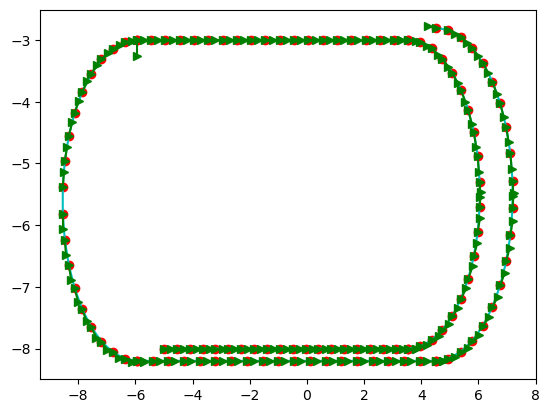

In [3]:
# Ground Truth Data
input_file = "./data/gt.txt"
gt_vertex = readVertex(input_file)
gt_edges = readEdge(input_file)
print(gt_vertex.shape)
draw(gt_vertex[0],gt_vertex[1],gt_vertex[2])

139
120


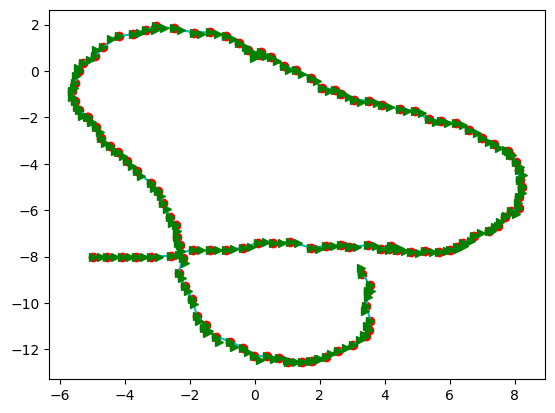

In [9]:
#code to generate the g2o file for edges.txt
input_file = "./data/edges.txt"
output_file = "./data/edges.g2o"

out = open(output_file, "w")

init = readVertex(input_file)
x = np.zeros(120)
y = np.zeros(120)
theta = np.zeros(120)
x[0] = init[0]
y[0] = init[1]
theta[0] = init[2]

ind1, ind2, dx, dy, dtheta = readEdge(input_file)
info_x_y_theta = "500.0 0.0 0.0 500.0 0.0 500.0"

print(len(ind1))

for i in range(len(x)-1):
    x[i+1] = x[i] + dx[i]*np.cos(theta[i]) - dy[i]*np.sin(theta[i])
    y[i+1] = y[i] + dx[i]*np.sin(theta[i]) + dy[i]*np.cos(theta[i])
    theta[i+1] = theta[i] + dtheta[i]

for i in range(len(x)):
    out.write("VERTEX_SE2" + " " + str(i) + " " + str(x[i]) + " " + str(y[i]) + " " + str(theta[i]) + "\n")

for i in range(len(ind1)):
    out.write("EDGE_SE2" + " " + str(ind1[i]) + " " + str(ind2[i]) + " " + str(dx[i]) + " " + str(dy[i]) + " " + str(dtheta[i]) + " " + info_x_y_theta + "\n")


out.write("FIX 0"+"\n")

print(np.size(x))
draw(x,y,theta)

In [10]:
#code to optimise this data with g2o
def optimize():
    cmd = "g2o -o ./data/optimal.g2o ./data/edges.g2o"
    os.system(cmd)
optimize()

Read input from ./data/edges.g2o
Loaded 120 vertices
Loaded 139 edges
# graph is fixed by priors or already fixed vertex
Initial chi2 = 409873.951679
saving ./data/optimal.g2o ... done.


(3, 120)


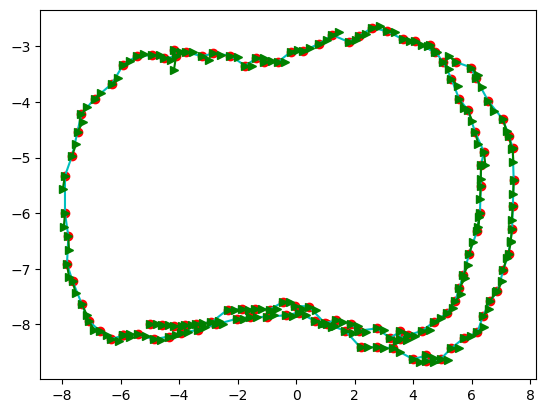

In [11]:
# Optimised Data
input_file = "./data/optimal.g2o"
gt_vertex = readVertex(input_file)
gt_edges = readEdge(input_file)
print(gt_vertex.shape)
draw(gt_vertex[0],gt_vertex[1],gt_vertex[2])

In [13]:
#to view in g2o_viewer

os.system("g2o_viewer ./data/optimal.g2o")
os.system("g2o_viewer ./data/gt.g2o")

0

### Evo (10 Points)
We need a measure of how good the trajectory is. The error/loss used earlier doesn't tell us much about how the trajectory differs from the ground truth. Here, we try to do just this - compute error metrics. Rather than computing these from scratch, we will just Evo - https://github.com/MichaelGrupp/evo/.

Look at the absolute pose error (APE) and relative pose error (RPE). What do they capture and how are they calculated (descriptive answer)? How do these metrics differ in methodology? Can we determine if the error is more along the x/y axis?

Answer the above questions and report errors for the obtained trajectory.

### ANS - rewrite

APE measures the absolute distance between corresponding positions in the estimated and ground truth trajectories. This error metric is useful for assessing the global accuracy of an estimated trajectory and understanding how much it deviates from the ground truth in an absolute sense.

APE is calculated as the Euclidean distance between corresponding points in the estimated and ground truth trajectories. 

Formally,APEi =∥p gt,i −p est,i ∥



RPE measures the difference in relative motion between consecutive poses in the estimated trajectory compared to the ground truth. This error is useful for capturing the accuracy of short-term motions, which is often essential in applications where smoothness and local consistency are critical.

Formally, RPEi =∥(T gt,i−1T gt,i+1)−(T est,i−1 T est,i+1)∥



APE focuses on the global alignment of trajectories, highlighting large-scale deviations. It accumulates error over time, giving a sense of cumulative drift.
RPE focuses on local consistency between consecutive poses, making it more sensitive to fluctuations or noise in trajectory estimation over short distances.


Evo’s APE and RPE metrics provide a general measure of positional error but don’t inherently break down error by the x, y, or z axes.

In [16]:
# Commands to convert to Kitti

# !python3 ./misc/g2o_to_kitti.py ./data/gt.g2o ./data/gt.kitti

# !python3 ./misc/g2o_to_kitti.py ./data/optimal.g2o ./data/optimal.kitti

# !python3 ./misc/g2o_to_kitti.py ./data/edges.g2o ./data/edges.kitti

Figure(640x480)
saved './data/edges.kitti' from './data/edges.g2o'


In [ ]:
# Commands to generate RPE Error Graphs
# evo_rpe kitti gt.kitti optimal.kitti -v --plot --plot_mode xy

# Terminal Output
# --------------------------------------------------------------------------------
# Loaded 120 poses from: gt.kitti
# Loaded 120 poses from: optimal.kitti
# --------------------------------------------------------------------------------
# Found 119 pairs with delta 1 (frames) among 120 poses using consecutive pairs.
# Compared 119 relative pose pairs, delta = 1 (frames) with consecutive pairs.
# Calculating RPE for translation part pose relation...
# --------------------------------------------------------------------------------
# RPE w.r.t. translation part (m)
# for delta = 1 (frames) using consecutive pairs
# (not aligned)

#        max      0.256174
#       mean      0.114585
#     median      0.101039
#        min      0.010550
#       rmse      0.129426
#        sse      1.993378
#        std      0.060177

# --------------------------------------------------------------------------------

<table>
    <tr>
        <td><h3>RPE Raw</h3><img src="./rpe 1.png" width="700"/></td>
        <td><h3>RPE Map</h3><img src="./rpe 2.png" width="700"/></td>
    </tr>
</table>

In [ ]:
# Commands to generate APE Error Graphs
# evo_ape kitti gt.kitti optimal.kitti -v --plot --plot_mode xy

# Terminal Output
# --------------------------------------------------------------------------------
# Loaded 120 poses from: gt.kitti
# Loaded 120 poses from: optimal.kitti
# --------------------------------------------------------------------------------
# Compared 120 absolute pose pairs.
# Calculating APE for translation part pose relation...
# --------------------------------------------------------------------------------
# APE w.r.t. translation part (m)
# (not aligned)

#        max      1.874801
#       mean      0.707642
#     median      0.557733
#        min      0.000000
#       rmse      0.886910
#        sse      94.393173
#        std      0.534652

# --------------------------------------------------------------------------------

<table>
    <tr>
        <td><h3>APE Raw</h3><img src="./ape 1.png" width="700"/></td>
        <td><h3>APE Map</h3><img src="./ape 2.png" width="700"/></td>
    </tr>
</table>

In [ ]:
# Commands to generate TRAJ Error Graphs
# evo_traj kitti gt.kitti optimal.kitti -v --plot --plot_mode xy

# Terminal Output
# --------------------------------------------------------------------------------
# Loaded 120 poses from: gt.kitti
# Loaded 120 poses from: optimal.kitti
# --------------------------------------------------------------------------------
# name:   gt
# infos:
#         nr. of poses    120
#         path length (m) 52.976517997999295
#         pos_end (m)     [-2.8 -4.5  0. ]
#         pos_start (m)   [-8.  5.  0.]
# --------------------------------------------------------------------------------
# name:   optimal
# infos:
#         nr. of poses    120
#         path length (m) 53.826783942922134
#         pos_end (m)     [-3.27918 -5.45836  0.     ]
#         pos_start (m)   [-8.  5.  0.]

# --------------------------------------------------------------------------------

<table>
    <tr>
        <td><h3>Trajectories</h3><img src="./traj1.png" width="700"/></td>
        <td><h3>XYZ</h3><img src="./traj2.png" width="700"/></td>
        <td><h3>RPY</h3><img src="./traj3.png" width="700"/></td>
    </tr>
</table>